# LendingClub Credit Risk Default Prediction

This notebook performs a complete data science pipeline:
1. Download dataset from Kaggle
2. Data cleaning and preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Machine Learning Model for Credit Risk Default Prediction

## Step 1: Install and Import Libraries

In [ ]:
# Install required packages (run once)
# !pip install pandas numpy matplotlib seaborn scikit-learn kaggle imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Step 2: Download Dataset from Kaggle

In [ ]:
pip install kaggle

In [2]:
import kaggle

print("Downloading LendingClub Dataset from Kaggle...")

# LendingClub dataset on Kaggle
dataset_name = "wordsforthewise/lending-club"

try:
    # Download dataset
    kaggle.api.dataset_download_files(dataset_name, path='./data', unzip=True)
    print("✓ Dataset downloaded successfully!")
    
    # Find the CSV file
    data_dir = Path('./data')
    csv_files = list(data_dir.glob('*.csv'))
    
    if csv_files:
        csv_path = str(csv_files[0])
        print(f"✓ Found CSV file: {csv_path}")
    else:
        print("⚠ No CSV file found.")
        csv_path = None
        
except Exception as e:
    print(f"✗ Error downloading dataset: {e}")
    print("\nAlternative: Download manually from:")
    print("https://www.kaggle.com/datasets/wordsforthewise/lending-club")
    csv_path = None

Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
✓ Dataset downloaded successfully!
✓ Found CSV file: data\accepted_2007_to_2018q4.csv


## Step 3: Load and Clean Data

In [3]:
# Load dataset
if csv_path:
    df = pd.read_csv("D:/newdads/BIng Project/accepted_2007_to_2018Q4.csv", low_memory=False)
    print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
else:
    # If download failed, specify path manually
    csv_path = input("Enter path to CSV file: ")
    df = pd.read_csv(csv_path, low_memory=False)
    print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset loaded: 2,260,701 rows × 151 columns


In [4]:
# Check missing values
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Top 20 columns with missing values:")
print(missing_df[missing_df['Missing Count'] > 0].head(20))

Top 20 columns with missing values:
                                            Missing Count   Missing %
member_id                                         2260701  100.000000
orig_projected_additional_accrued_interest        2252050   99.617331
hardship_reason                                   2249784   99.517097
hardship_payoff_balance_amount                    2249784   99.517097
hardship_last_payment_amount                      2249784   99.517097
payment_plan_start_date                           2249784   99.517097
hardship_type                                     2249784   99.517097
hardship_status                                   2249784   99.517097
hardship_start_date                               2249784   99.517097
deferral_term                                     2249784   99.517097
hardship_amount                                   2249784   99.517097
hardship_dpd                                      2249784   99.517097
hardship_loan_status                              2249

In [5]:
# Remove duplicates
initial_rows = len(df)
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicates. Rows: {initial_rows:,} → {len(df):,}")

Duplicate rows: 0


In [6]:
# Create target variable
if 'loan_status' in df.columns:
    print("Loan Status Distribution:")
    print(df['loan_status'].value_counts())
    
    # Create binary target
    df['is_default'] = df['loan_status'].apply(
        lambda x: 1 if x in ['Charged Off', 'Default', 'Late (31-120 days)', 
                            'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off'] 
        else 0 if x in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'] 
        else np.nan
    )
    
    print(f"\nBinary Target Distribution:")
    print(f"Default (1): {df['is_default'].sum():,}")
    print(f"Fully Paid (0): {(df['is_default'] == 0).sum():,}")

Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Binary Target Distribution:
Default (1): 295,176.0
Fully Paid (0): 1,078,739


In [7]:
# Convert data types
# Date columns
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Percentage columns
pct_columns = [col for col in df.columns if 'pct' in col.lower() or 'rate' in col.lower()]
for col in pct_columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.rstrip('%').astype(float) / 100.0
        except:
            pass

print("✓ Data type conversions completed")

✓ Data type conversions completed


In [8]:
# Drop columns with >50% missing values
threshold = 0.5
cols_to_drop = missing_df[missing_df['Missing %'] > threshold * 100].index.tolist()
if cols_to_drop:
    print(f"Dropping {len(cols_to_drop)} columns with >{threshold*100}% missing values")
    df = df.drop(columns=cols_to_drop)

print(f"Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dropping 44 columns with >50.0% missing values
Final dataset shape: 2,260,701 rows × 108 columns


## Step 4: Exploratory Data Analysis (EDA)

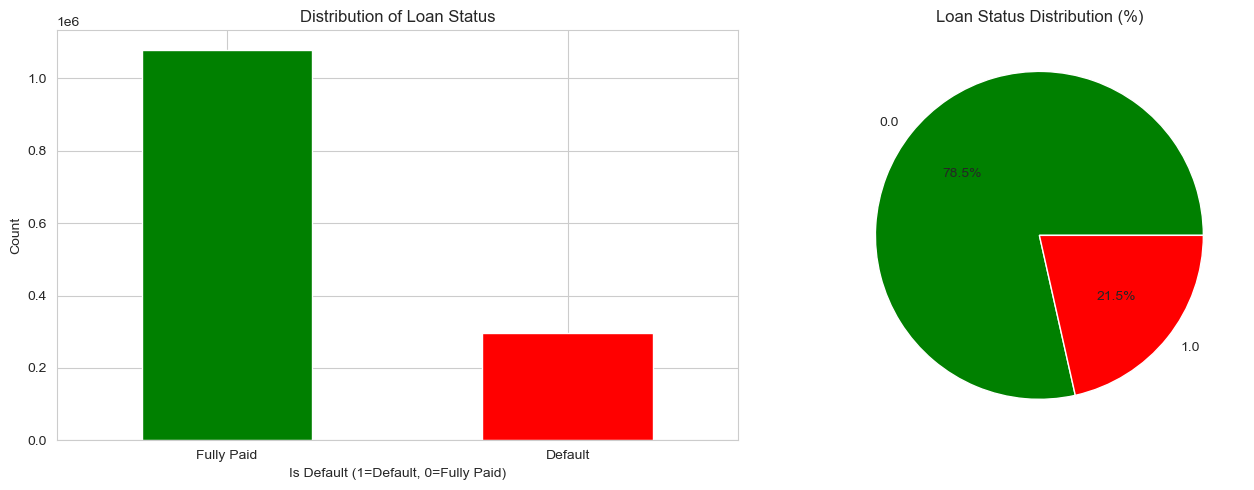

In [9]:
# Target variable distribution
if 'is_default' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    df['is_default'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
    axes[0].set_title('Distribution of Loan Status')
    axes[0].set_xlabel('Is Default (1=Default, 0=Fully Paid)')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['Fully Paid', 'Default'], rotation=0)
    
    df['is_default'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                                      autopct='%1.1f%%', colors=['green', 'red'])
    axes[1].set_title('Loan Status Distribution (%)')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

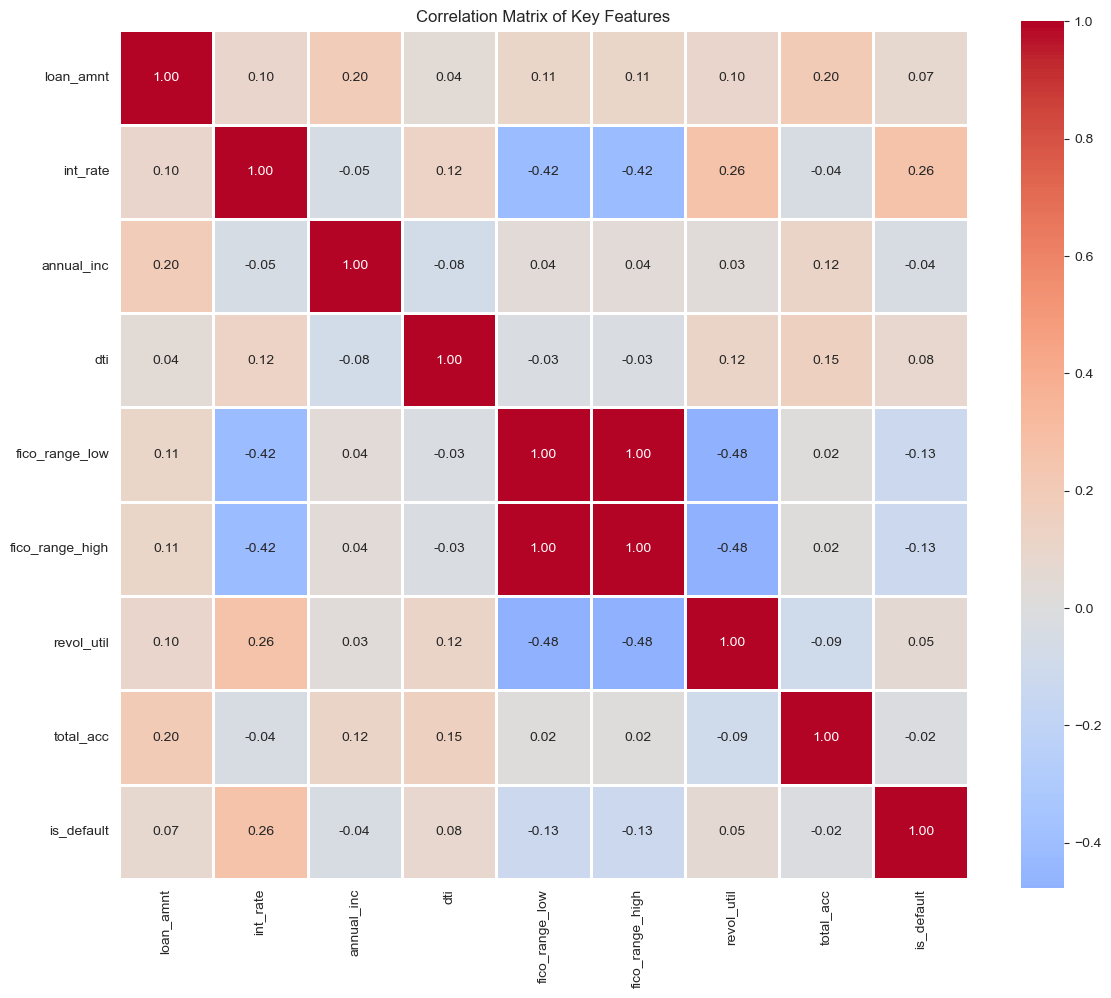

In [10]:
# Correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
important_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 
                 'fico_range_high', 'revol_util', 'total_acc', 'is_default']
available_cols = [col for col in important_cols if col in df.columns]

if len(available_cols) > 2:
    corr_matrix = df[available_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
               center=0, square=True, linewidths=1)
    plt.title('Correlation Matrix of Key Features')
    plt.tight_layout()
    plt.show()

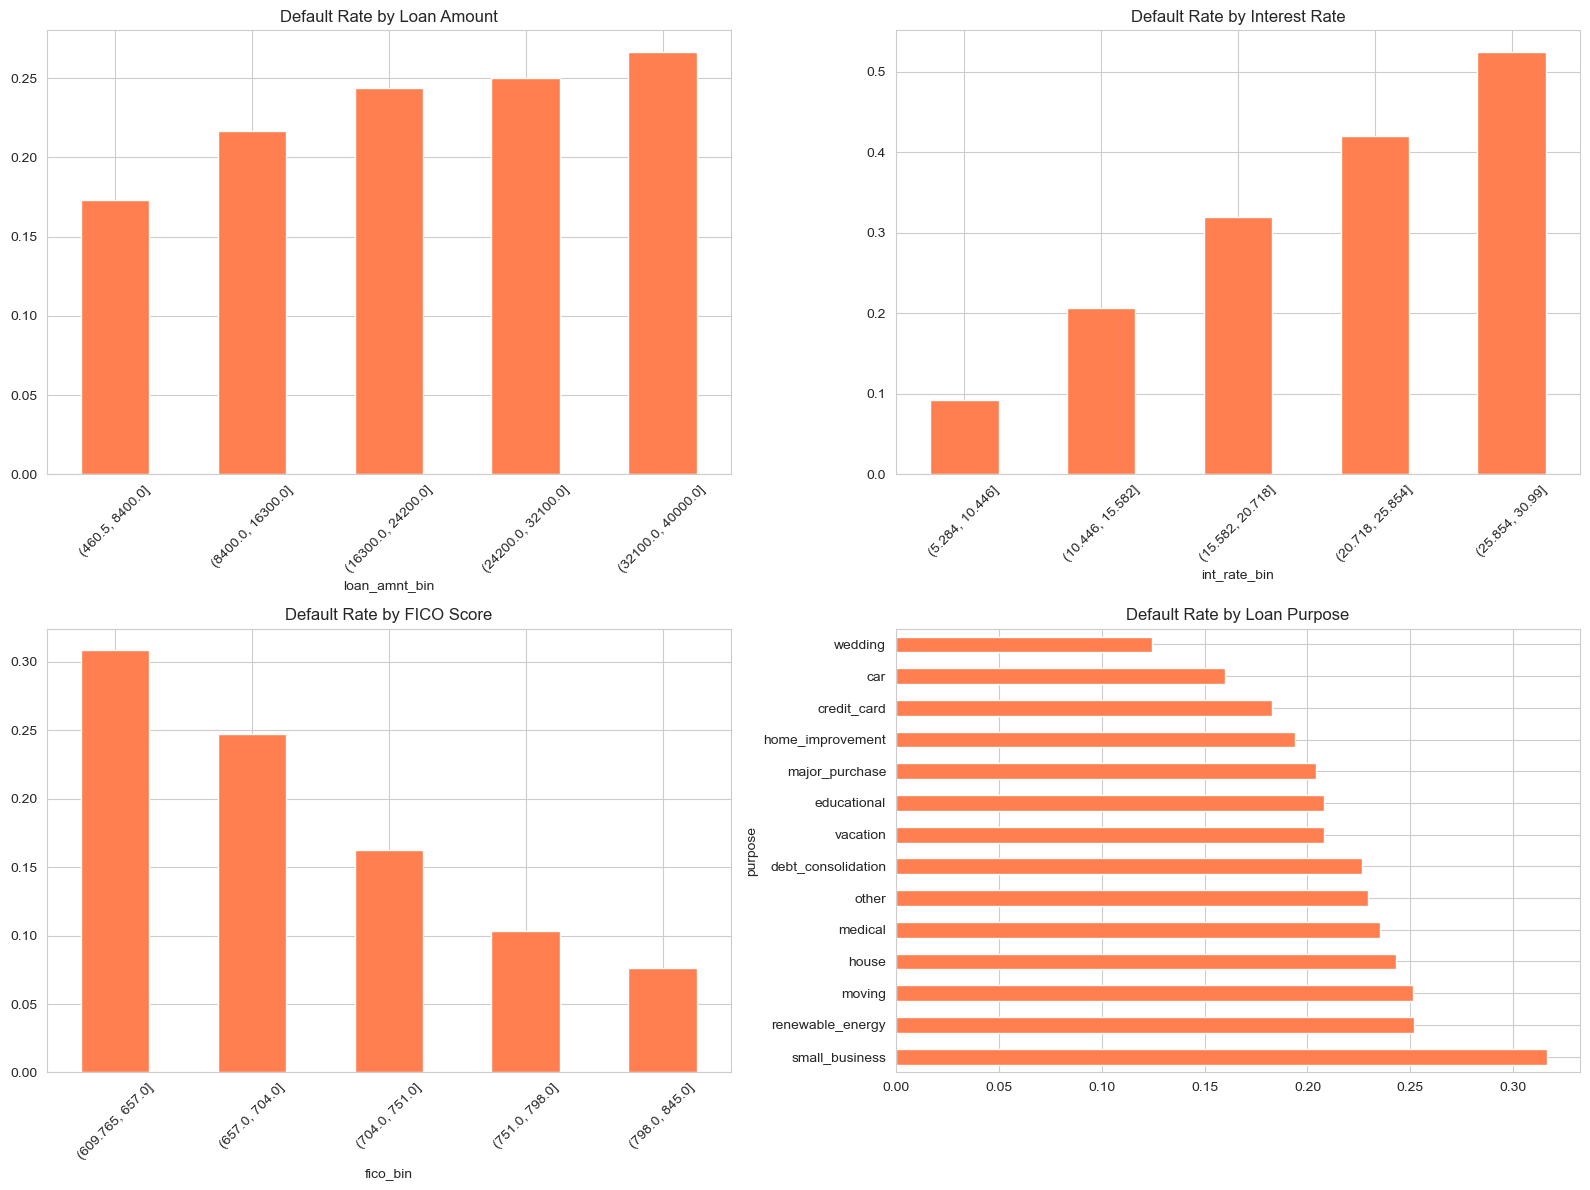

In [11]:
# Default rate by key features
if 'is_default' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # By loan amount
    if 'loan_amnt' in df.columns:
        df['loan_amnt_bin'] = pd.cut(df['loan_amnt'], bins=5)
        default_by_loan = df.groupby('loan_amnt_bin')['is_default'].mean()
        default_by_loan.plot(kind='bar', ax=axes[0, 0], color='coral')
        axes[0, 0].set_title('Default Rate by Loan Amount')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # By interest rate
    if 'int_rate' in df.columns:
        df['int_rate_bin'] = pd.cut(df['int_rate'], bins=5)
        default_by_int = df.groupby('int_rate_bin')['is_default'].mean()
        default_by_int.plot(kind='bar', ax=axes[0, 1], color='coral')
        axes[0, 1].set_title('Default Rate by Interest Rate')
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # By FICO score
    if 'fico_range_low' in df.columns:
        df['fico_bin'] = pd.cut(df['fico_range_low'], bins=5)
        default_by_fico = df.groupby('fico_bin')['is_default'].mean()
        default_by_fico.plot(kind='bar', ax=axes[1, 0], color='coral')
        axes[1, 0].set_title('Default Rate by FICO Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # By purpose
    if 'purpose' in df.columns:
        default_by_purpose = df.groupby('purpose')['is_default'].mean().sort_values(ascending=False)
        default_by_purpose.plot(kind='barh', ax=axes[1, 1], color='coral')
        axes[1, 1].set_title('Default Rate by Loan Purpose')
    
    plt.tight_layout()
    plt.show()

## Step 5: Feature Engineering

In [12]:
# Handle missing values
df_processed = df.copy()

# Numerical columns: impute with median
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'is_default' in numeric_cols:
    numeric_cols.remove('is_default')

imputer_numeric = SimpleImputer(strategy='median')
df_processed[numeric_cols] = imputer_numeric.fit_transform(df_processed[numeric_cols])
print(f"✓ Imputed {len(numeric_cols)} numerical columns")

✓ Imputed 83 numerical columns


In [13]:
# Create new features
# FICO average
if 'fico_range_low' in df_processed.columns and 'fico_range_high' in df_processed.columns:
    df_processed['fico_avg'] = (df_processed['fico_range_low'] + df_processed['fico_range_high']) / 2
    print("✓ Created: fico_avg")

# DTI categories
if 'dti' in df_processed.columns:
    df_processed['dti_category'] = pd.cut(df_processed['dti'], 
                                           bins=[0, 10, 20, 30, 100], 
                                           labels=['Low', 'Medium', 'High', 'Very High'])
    print("✓ Created: dti_category")

# Loan to income ratio
if 'loan_amnt' in df_processed.columns and 'annual_inc' in df_processed.columns:
    df_processed['loan_to_income'] = df_processed['loan_amnt'] / (df_processed['annual_inc'] + 1)
    print("✓ Created: loan_to_income")

# Credit history years
if 'earliest_cr_line' in df_processed.columns and 'issue_d' in df_processed.columns:
    df_processed['earliest_cr_line'] = pd.to_datetime(df_processed['earliest_cr_line'], errors='coerce')
    df_processed['issue_d'] = pd.to_datetime(df_processed['issue_d'], errors='coerce')
    df_processed['credit_history_years'] = (
        (df_processed['issue_d'] - df_processed['earliest_cr_line']).dt.days / 365.25
    )
    print("✓ Created: credit_history_years")

✓ Created: fico_avg
✓ Created: dti_category
✓ Created: loan_to_income
✓ Created: credit_history_years


In [14]:
# Encode categorical variables
important_categorical = ['grade', 'sub_grade', 'home_ownership', 'purpose', 'emp_length', 'verification_status']
label_encoders = {}

for col in important_categorical:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"✓ Encoded: {col}")

✓ Encoded: grade
✓ Encoded: sub_grade
✓ Encoded: home_ownership
✓ Encoded: purpose
✓ Encoded: emp_length
✓ Encoded: verification_status


In [15]:
# Select features for modeling
feature_columns = []

# Numerical features
important_numeric = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_avg', 
                     'revol_util', 'total_acc', 'loan_to_income', 'credit_history_years']
feature_columns.extend([col for col in important_numeric if col in df_processed.columns])

# Encoded categorical features
encoded_categorical = [col + '_encoded' for col in important_categorical]
feature_columns.extend([col for col in encoded_categorical if col in df_processed.columns])

# Prepare X and y
if 'is_default' in df_processed.columns:
    X = df_processed[feature_columns].copy()
    y = df_processed['is_default'].copy()
    
    # Remove rows where target is NaN
    valid_mask = y.notna()
    X = X[valid_mask]
    y = y[valid_mask]
    
    print(f"\n✓ Feature engineering completed!")
    print(f"  Features: {len(feature_columns)}")
    print(f"  Samples: {len(X):,}")
    print(f"  Default rate: {y.mean():.2%}")


✓ Feature engineering completed!
  Features: 15
  Samples: 1,373,915
  Default rate: 21.48%


## Step 6: Machine Learning Model

In [16]:
# Handle remaining missing values
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 1,099,132 samples
Test set: 274,783 samples


In [17]:
# Run the cells below first: 'Scale features' and 'Train models', then run the 'Accuracy checking' cell.


In [18]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Training set: {X_train_resampled.shape[0]:,} samples")
print(f"Class distribution: Default={y_train_resampled.sum()}, Fully Paid={(y_train_resampled==0).sum()}")

After SMOTE - Training set: 1,725,982 samples
Class distribution: Default=862991.0, Fully Paid=862991


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

✓ Features scaled


In [20]:
# Train models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train_resampled)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score
    }
    
    print(f"  AUC Score: {auc_score:.4f}")


Training Logistic Regression...
  AUC Score: 0.6483

Training Random Forest...
  AUC Score: 0.6820

Training Gradient Boosting...
  AUC Score: 0.6731


In [21]:
# Accuracy checking for all models
from sklearn.metrics import accuracy_score

print("Model performance (test set):\n")
accuracy_summary = []

for name, result in results.items():
    y_pred = result['predictions']
    acc = accuracy_score(y_test, y_pred)
    auc = result['auc_score']
    accuracy_summary.append({'Model': name, 'Accuracy (%)': round(acc * 100, 2), 'AUC-ROC': round(auc, 4)})
    print(f"  {name}: Accuracy = {acc*100:.2f}%  |  AUC-ROC = {auc:.4f}")

# Summary table
accuracy_df = pd.DataFrame(accuracy_summary)
print("\n--- Summary table ---")
print(accuracy_df.to_string(index=False))

# Best model by accuracy
best_by_acc = accuracy_df.loc[accuracy_df['Accuracy (%)'].idxmax()]
print(f"\nBest model by accuracy: {best_by_acc['Model']} with {best_by_acc['Accuracy (%)']}% accuracy.")

Model performance (test set):

  Logistic Regression: Accuracy = 65.39%  |  AUC-ROC = 0.6483
  Random Forest: Accuracy = 75.89%  |  AUC-ROC = 0.6820
  Gradient Boosting: Accuracy = 73.63%  |  AUC-ROC = 0.6731

--- Summary table ---
              Model  Accuracy (%)  AUC-ROC
Logistic Regression         65.39   0.6483
      Random Forest         75.89   0.6820
  Gradient Boosting         73.63   0.6731

Best model by accuracy: Random Forest with 75.89% accuracy.


In [22]:
# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['auc_score'])
best_model = results[best_model_name]['model']

print(f"Best Model: {best_model_name}")
print(f"AUC Score: {results[best_model_name]['auc_score']:.4f}")

# Classification report
y_pred_best = results[best_model_name]['predictions']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Fully Paid', 'Default']))

Best Model: Random Forest
AUC Score: 0.6820

Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.81      0.90      0.85    215748
     Default       0.40      0.25      0.31     59035

    accuracy                           0.76    274783
   macro avg       0.61      0.57      0.58    274783
weighted avg       0.73      0.76      0.74    274783



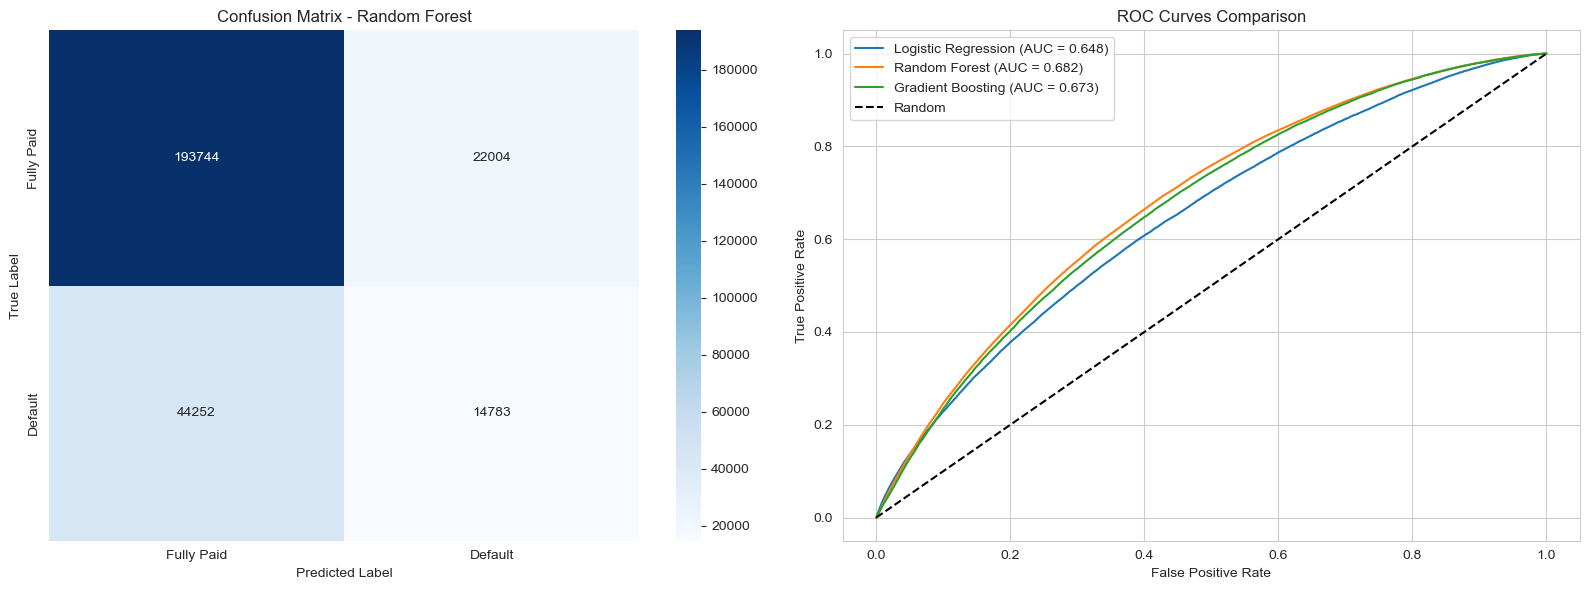

In [23]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
axes[0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {result["auc_score"]:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Top 15 Feature Importances:
                        feature  importance
1                      int_rate    0.172032
4                      fico_avg    0.083667
10            sub_grade_encoded    0.083286
7                loan_to_income    0.074127
3                           dti    0.073011
11       home_ownership_encoded    0.071844
5                    revol_util    0.067854
8          credit_history_years    0.067206
6                     total_acc    0.063704
2                    annual_inc    0.059062
0                     loan_amnt    0.055019
9                 grade_encoded    0.037894
13           emp_length_encoded    0.034997
12              purpose_encoded    0.032866
14  verification_status_encoded    0.023432


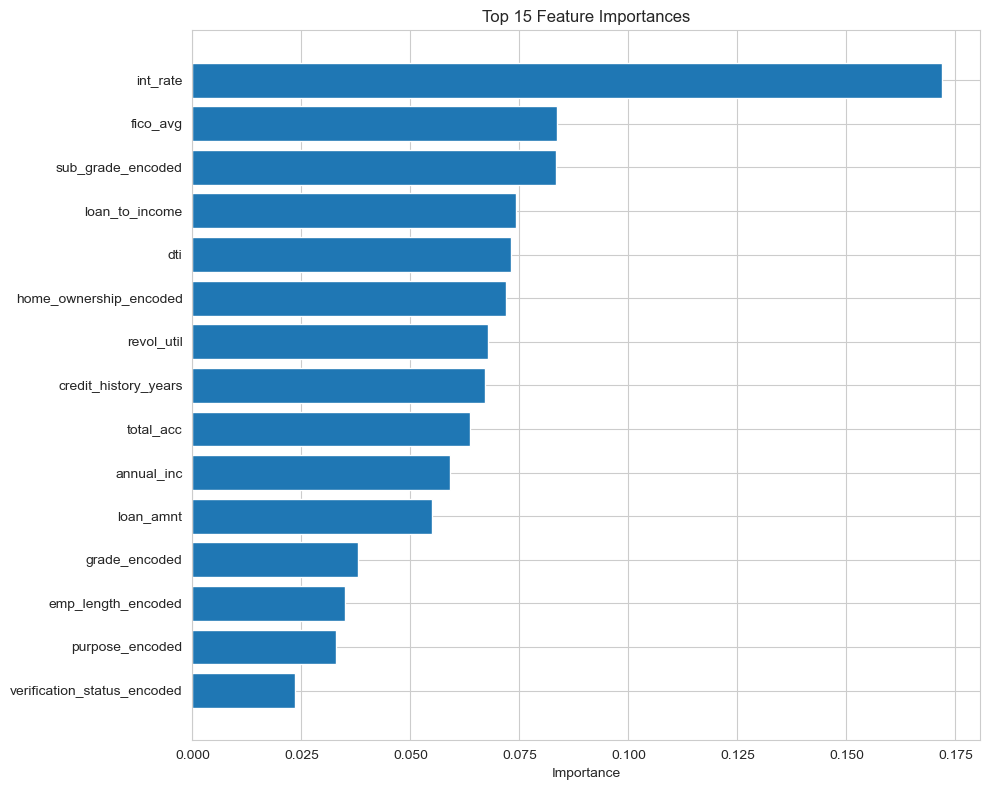

In [24]:
# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Feature Importances:")
    print(feature_importance.head(15))
    
    # Plot
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Summary

The project has successfully:
1. ✓ Downloaded/loaded the LendingClub dataset
2. ✓ Cleaned the data (handled nulls, duplicates, data types)
3. ✓ Performed comprehensive EDA
4. ✓ Engineered new features
5. ✓ Trained and evaluated ML models for credit risk prediction

The best model can now be used to predict loan defaults on new data!